<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/VQAWithQFormer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Question Answering with Q-Formers
Visual Question Answering using hugging face's q-former

largely informed by https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BLIP-2/Chat_with_BLIP_2_%5Bint8_bitsandbytes%5D.ipynb#scrollTo=nxq1Gl9SDD5B

**Resources:**

This notebook requires a high System Ram instance and a T4 GPU to run. My resource consumption was around:
- 8.3GB/51.0GB System RAM
- 5.2/15GB GPU RAM

It might seem like by System RAM is overallocated. However, when swiching over to a low 12.7GB System Ram instance I ran out of memory. I suspect that 8.3GB figure is not perfectly accurate, and the actual System RAM consumption is around 15GB.


## Installing Dependencies
**huggingface/transformers**: provides APIs and tools to easily download and train state-of-the-art pretrained models. It's what we'll use to install BLIP-2.

**accelerate**: Is a model portability module by huggingface which is necessary for BLIP-2 to load and run correctly

**bitsandbytes**: Is a lightweight wrapper over CUDA (GPU) operations which allows for memory efficient computation, and is necessary for BLIP-2 to load and run correctly. [info](https://huggingface.co/blog/hf-bitsandbytes-integration)

In [1]:
!pip install git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-c8jat9et
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-c8jat9et
  Resolved https://github.com/huggingface/transformers.git to commit 897a826d830e8b1e03eb482b165b5d88a7a08d5f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.35.0.dev0-py3-none-any.whl size=7745571 sha256=ef32cf52d468d1d14d014bff594b7

# Downloading Blip-2
There are several ways to load the model:
```
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b") # load in float32
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) # load in float16
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8
```

We'll be loading the model as an 8 bit integer to save on resources, but you might find the model performs better with larger datatypes. This model was trained on a single A100 GPU, so that should be sufficent for the larger models (though I haven't tested that).

You might notice the model gets downloaded in two parts: the `processor` and the `model`. in looking at [huggingfaces documentation on processors](https://huggingface.co/docs/transformers/main_classes/processors), I suspect that the `processor` is the CLIP style image encoder while the `model` is the Q-former and language model packaged into a single PyTorch model.

In [2]:
"""Downloading the BLIP-2 Architecture
loading as an 8 bit integer to save on GPU memory. This may have some impact on
performance.
"""

from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True) # load in int8

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Passing the image through the processor to see what we get

Image dimensions: 4608px X 6144px


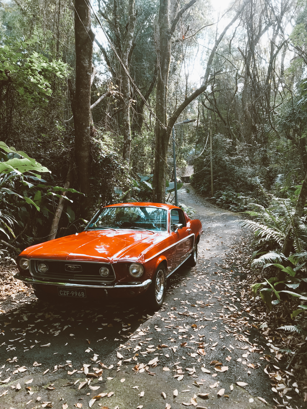

In [3]:
"""Loading and displaying a sample image
"""

import requests
from PIL import Image

url = 'https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Images/pexels-thuany-marcante-1805053.jpg?raw=true'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

print(f'Image dimensions: {image.width}px X {image.height}px')

dsfact = 15
display(image.resize((int(image.width/dsfact), int(image.height/dsfact))))

In [4]:
"""Exploring the outputs of the processor
"""
processor_result = processor(image, text='a prompt from the user about the image', return_tensors="pt").to("cpu", torch.float16)
processor_result.keys()

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])

# Understanding pixel_values
It appears the processor modifies the image in 2 ways:
- normalizes the values on each color channel (squashes the values between 0 and 1)
- resizes the image to be 224x224 pixels

processed image shape: (1, 3, 224, 224)
single color channel:


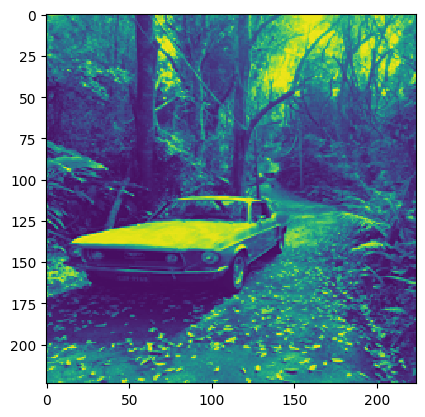

In [5]:
"""Understanding resolution and plotting one of the color channels
"""

import matplotlib.pyplot as plt

#printing the processed image shape
print(f'processed image shape: {processor_result["pixel_values"].numpy().shape}')

#extracting one of the color channels from the processed image
print('single color channel:')
processed_im_c0 = processor_result['pixel_values'].numpy()[0,0]

#rendering
plt.imshow(processed_im_c0, interpolation='nearest')
plt.show()

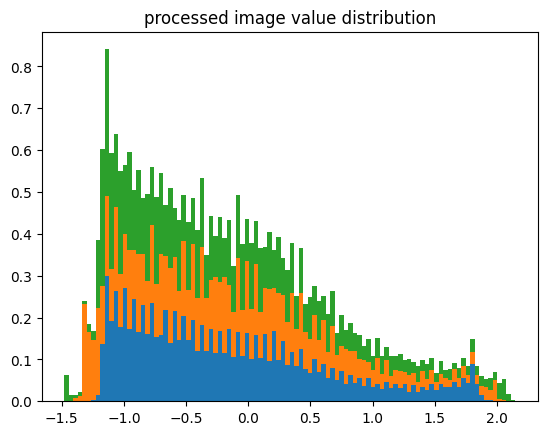

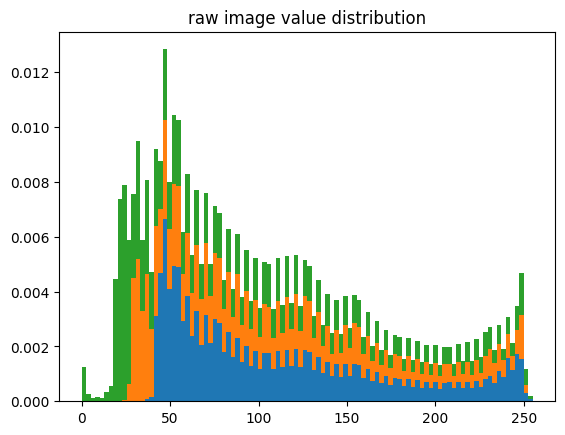

In [6]:
"""Understanding the distribution of values allong each color channel,
both in the processed image and in the original image
"""

bins = 100

#extracting all color channels from the processed image
processed_im_c1 = processor_result['pixel_values'].numpy()[0,1]
processed_im_c2 = processor_result['pixel_values'].numpy()[0,2]

#plotting modified pixel value distributions

plt.figure()
plt.hist([processed_im_c0.flatten(),
          processed_im_c1.flatten(),
          processed_im_c2.flatten()], bins, stacked=True, density = True)
plt.title('processed image value distribution')
plt.show()

#plotting original pixel value distributions
import numpy as np
image_np = np.array(image)

plt.figure()
plt.hist([image_np[:,:,0].flatten(),
          image_np[:,:,1].flatten(),
          image_np[:,:,2].flatten()], bins, stacked=True, density = True)
plt.title('raw image value distribution')
plt.show()

# Exploring input IDs
these appear to be word piece id's extracted from the input prompt

In [7]:
"""Exploring the input_ids from the processor given a variety of prompts
"""

print('input_ids for "a short prompt":')
sampres = processor(image, text='a short prompt', return_tensors="pt").to("cpu", torch.float16)
print(sampres['input_ids'])

print('input_ids for "a much much much much longer prompt":')
sampres = processor(image, text='a much much much much longer prompt', return_tensors="pt").to("cpu", torch.float16)
print(sampres['input_ids'])

print('input_ids for "alongcompoundword":')
sampres = processor(image, text='alongcompoundword', return_tensors="pt").to("cpu", torch.float16)
print(sampres['input_ids'])

input_ids for "a short prompt":
tensor([[    2,   102,   765, 14302]])
input_ids for "a much much much much longer prompt":
tensor([[    2,   102,   203,   203,   203,   203,  1181, 14302]])
input_ids for "alongcompoundword":
tensor([[    2, 20774, 11828,  9834, 14742]])


In [8]:
"""Understanding the mask from the processor
"""

print('input_ids for "a short prompt":')
sampres = processor(image, text='a short prompt', return_tensors="pt").to("cpu", torch.float16)
print(sampres['input_ids'])
print('mask for "a short prompt":')
print(sampres['attention_mask'])

input_ids for "a short prompt":
tensor([[    2,   102,   765, 14302]])
mask for "a short prompt":
tensor([[1, 1, 1, 1]])


# Exploring the entire processor
Looking at the printout from the processor, my guess is:
- it converts the image to rgb, if it isn't.
- it normalizes allong the R, G, and B channels seperatly
- is rescales (with aliasing) to a size close to 224x224
- it resizes to exactly 224x224
- it tokenizes the prompt with `GPT2TokenizerFast`

In [9]:
processor

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


Blip2Processor:
- image_processor: BlipImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "BlipImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "Blip2Processor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

- tokenizer: GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=Fa

In [11]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

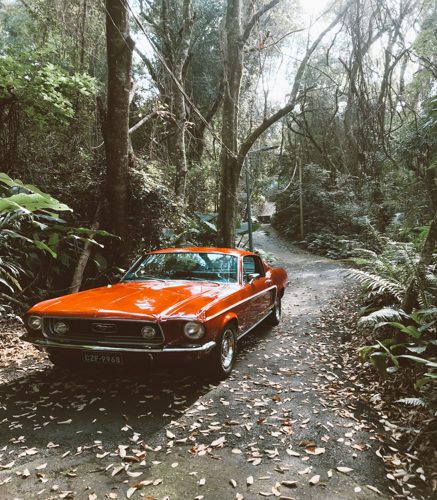

In [12]:
import requests
from PIL import Image

url = 'https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Images/pexels-thuany-marcante-1805053.jpg?raw=true'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
display(image.resize((437, 500)))

# Image Captioning

In [13]:
"""Getting BLIP-2 to describe the image, unprompted
this is done by only passing the image, not the text
"""
inputs = processor(image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

an orange car parked in the woods


# Prompted image captioning

In [15]:
"""Prompted caption 1
"""

prompt = "this is a picture of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

an orange car parked in the woods


In [16]:
"""Prompted caption 2
"""

prompt = "the weather looks"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

like it's going to be perfect for a drive in the forest


# Visual Question Answering

In [31]:
prompt = "Question: what season is it? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

it's autumn in the south island of new zealand


# Visual Conversation

In [18]:
context = [
    ("what season is it?", "it's autumn in the south island of new zealand"),
    ("why?", "it has a statue of a merlion"),
]
question = "where is the name merlion coming from?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: what carries electricity in this  Answer: singapore. Question: why? Answer: it has a statue of a merlion. Question: where is the name merlion coming from? Answer:


In [52]:
"""Visual Conversation
conversing about the image
"""

#imagine these are generated by a person as a response to output, rather than pre-defined.
questions = [
    "What's in this photo?",
    "What is vernacular architecture?"
]

#defining the state of the conversation as it progresses, to be passed to the model
conv_state = ''

#asking all questions in order
for question in questions:
    #updating the conversational state with the question
    conv_state = conv_state+' Question: ' + question + ' Answer: '

    #passing the state thus far to the model
    inputs = processor(image, text=conv_state, return_tensors="pt").to(device, torch.float16)

    #generating a response
    generated_ids = model.generate(**inputs, max_new_tokens=40)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    #rendering conversation
    print('Question: '+question)
    print('Answer: ' + generated_text)

    #updating the conversational state with the answer
    conv_state = conv_state + generated_text + '\n'

Question: What's in this photo?
Answer: vernacular architecture, a classic car, and a forest
Question: What is vernacular architecture?
Answer: vernacular architecture is a style of architecture that is built in a way that is familiar to the people who live in the area
